In [1]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Import of full_df 



In [2]:
full_df = pd.read_pickle('../data/processed/full_df.pkl')
full_df

,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,block_time,flt_event_number,block_delay,ground_delay,rot_mismatch,rows_to_drop,rows_to_drop_grounddelay,last_flt
0,272024970,East Carmen Airlines,EC3292,New Jessica,East Carmen,2019-06-01,2019-06-01 03:25:00,2019-06-01,2019-06-01 06:45:00,2019-06-01 03:50:00,2019-06-01 07:01:00,ECLBAX,other problem,25.0,320,0,0,95.0,94.0,2019-06-01,321,ECLBAX,45.0,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95.0,272024970.0,272022230.0,27.0,NaN,25.0,191.0,1,-9.0,25.0,False,0,0,0.0
1,272022230,East Carmen Airlines,EC3257,East Carmen,South Nathaniel,2019-06-01,2019-06-01 08:20:00,2019-06-01,2019-06-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,320,60,60,75.0,120.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,126.0,2,-9.0,15.0,False,0,0,0.0
2,272212848,East Carmen Airlines,EC3258,South Nathaniel,East Carmen,2019-06-01,2019-06-01 11:50:00,2019-06-01,2019-06-01 14:15:00,2019-06-01 12:41:00,2019-06-01 14:52:00,ECLBAX,rotational problem,51.0,320,68,75,80.0,86.0,2019-06-01,321,ECLBAX,45.0,South Nathaniel,East Carmen,Joneshaven,2019-06-01 11:50:00,2019-06-01 14:15:00,2019-06-01 15:35:00,2019-06-01 17:00:00,80.0,272212848.0,271997824.0,25.0,NaN,NaN,131.0,3,-14.0,51.0,False,0,0,0.0
3,271997824,East Carmen Airlines,EC3021,East Carmen,Joneshaven,2019-06-01,2019-06-01 15:35:00,2019-06-01,2019-06-01 17:00:00,2019-06-01 16:18:00,2019-06-01 17:32:00,ECLBAX,rotational problem,43.0,320,64,70,50.0,32.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,74.0,4,-11.0,43.0,False,0,0,0.0
4,271998033,East Carmen Airlines,EC3022,Joneshaven,East Carmen,2019-06-01,2019-06-01 17:50:00,2019-06-01,2019-06-01 19:10:00,2019-06-01 18:04:00,2019-06-01 19:14:00,ECLBAX,other problem,14.0,320,42,50,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,70.0,5,-10.0,14.0,False,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12180,272211046,East Carmen Airlines,EC3234,Lisamouth,East Carmen,2019-06-30,2019-06-30 10:30:00,2019-06-30,2019-06-30 12:10:00,2019-06-30 10:34:00,2019-06-30 12:05:00,ECLXEX,other problem,4.0,320,37,45,50.0,85.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,91.0,3,-9.0,4.0,False,0,0,0.0
12181,271969272,East Carmen Airlines,EC2687,East Carmen,West Jason,2019-06-30,2019-06-30 13:00:00,2019-06-30,2019-06-30 14:15:00,2019-06-30 13:30:00,2019-06-30 14:36:00,ECLXEX,rotational problem,30.0,320,0,0,45.0,54.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,66.0,4,-9.0,30.0,False,0,0,0.0
12182,271969452,East Carmen Airlines,EC2688,West Jason,East Carmen,2019-06-30,2019-06-30 15:00:00,2019-06-30,2019-06-30 16:20:00,2019-06-30 15:30:00,2019-06-30 16:40:00,ECLXEX,rotational problem,30.0,320,41,45,45.0,57.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,70.0,5,-10.0,30.0,False,0,0,0.0
12183,272187492,East Carmen Airlines,EC2693,East Carmen,West Jason,2019-06-30,2019-06-30 17:05:00,2019-06-30,2019-06-30 18:20:00,2019-06-30 17:37:00,2019-06-30 19:01:00,ECLXEX,rotational problem,32.0,320,50,45,45.0,4.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,84.0,6,9.0,32.0,False,0,0,0.0


<AxesSubplot:>

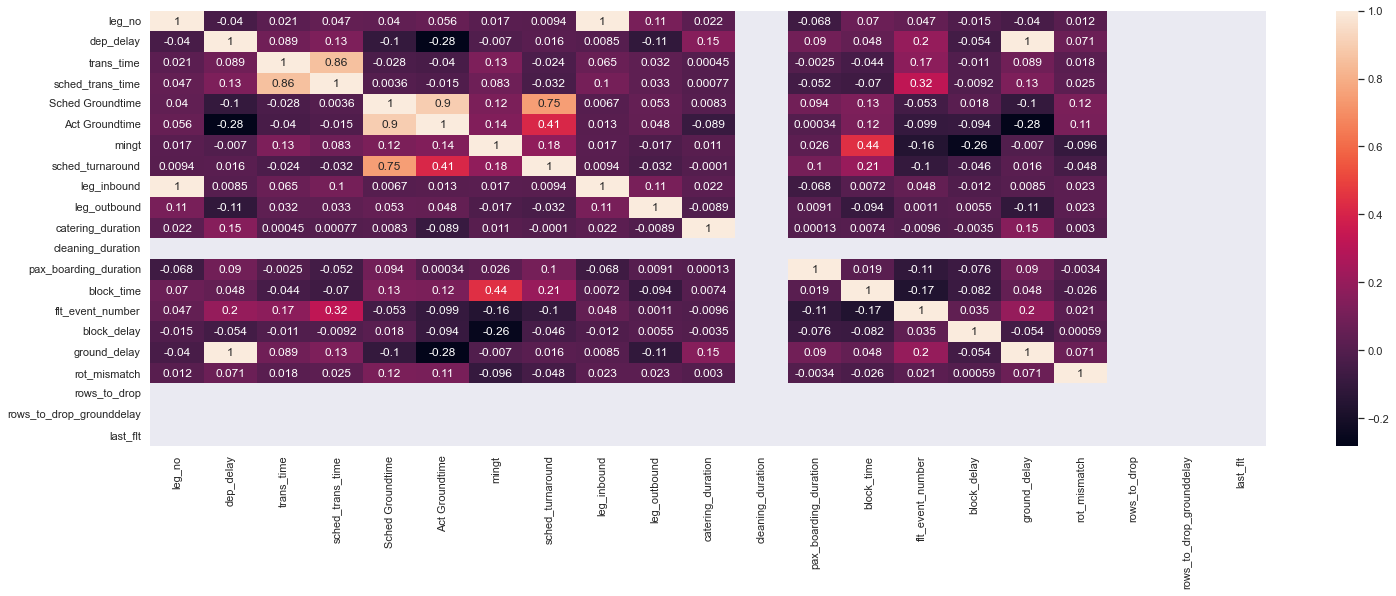

In [4]:
# Correlation Matrix
sns.set(rc={'figure.figsize':(25, 8)})
corr_ground = full_df[full_df['rows_to_drop_grounddelay']==0].corr()
sns.heatmap(corr_ground, annot=True)

In [60]:
corr_ground['ground_delay'].sort_values()

Act Groundtime             -0.280842
leg_outbound               -0.112816
Sched Groundtime           -0.104374
block_delay                -0.053559
leg_no                     -0.040046
mingt                      -0.006952
leg_inbound                 0.008452
sched_turnaround            0.015913
block_time                  0.048013
rot_mismatch                0.070635
trans_time                  0.088811
pax_boarding_duration       0.090207
sched_trans_time            0.126490
catering_duration           0.151006
flt_event_number            0.197370
ground_delay                1.000000
dep_delay                   1.000000
cleaning_duration                NaN
rows_to_drop                     NaN
rows_to_drop_grounddelay         NaN
last_flt                         NaN
Name: ground_delay, dtype: float64

Hypothesis 4: Time of day has influence on dep delay

<AxesSubplot:xlabel='Min_of_Day', ylabel='ground_delay'>

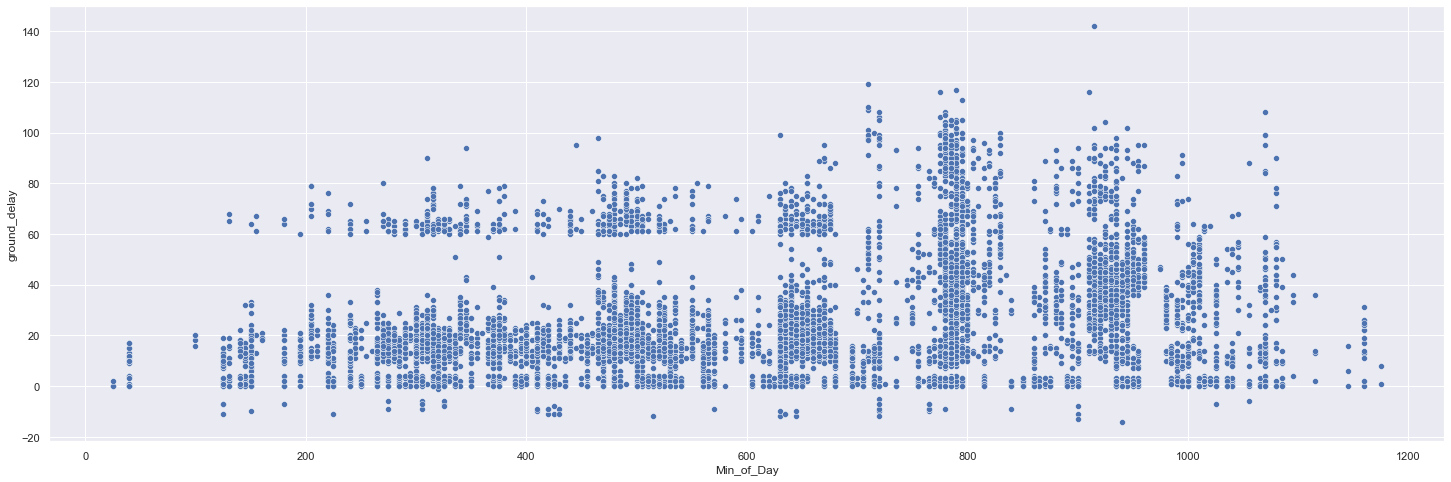

In [63]:
temp = full_df[full_df['rows_to_drop_grounddelay']==0][['dep_sched_time', 'ground_delay']]

temp['Min_of_Day'] = temp['dep_sched_time'].dt.hour*60 + temp['dep_sched_time'].dt.minute


sns.set(rc={'figure.figsize':(25, 8)})
sns.scatterplot(x=temp['Min_of_Day'], y=temp['ground_delay'])


<AxesSubplot:>

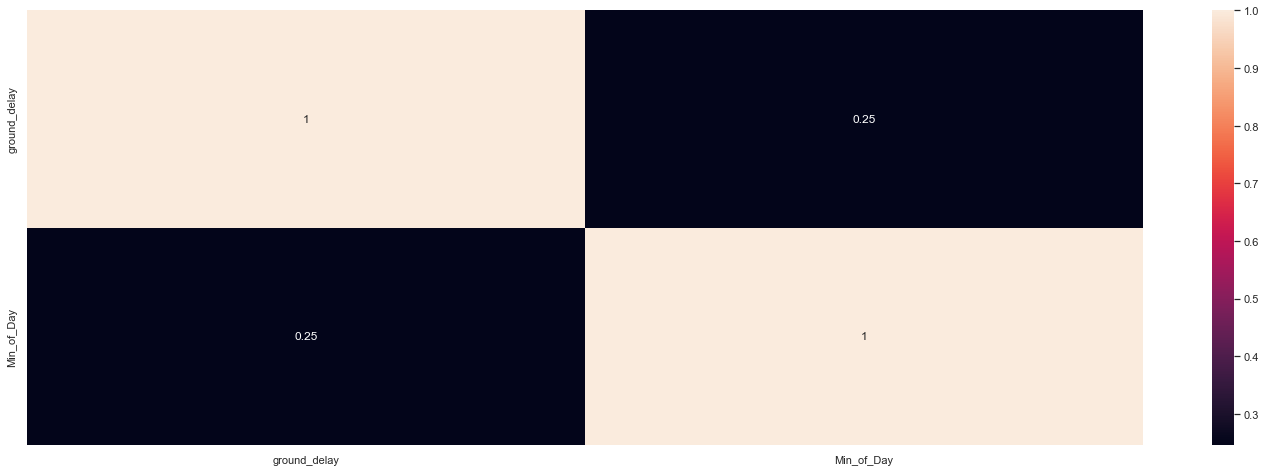

In [64]:
sns.heatmap(temp.corr(), annot = True)